In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy.stats import norm, skew
from scipy import stats
import statsmodels.api as sm
import talib
import warnings

# 경고 문구를 뜨지 않도록 해줌
warnings.filterwarnings('ignore')

# 그래프 형식 설정
plt.style.use('fivethirtyeight')

# Replication

In [2]:
# 데이터 로드
df1 = pd.read_csv('data/crsp2.csv')
df = pd.read_csv('data/crsp sp500.csv')

# 채권&CPI 데이터와 SP500 데이터 결합
df1 = df1.merge(df, on=['caldt'])

# 날짜 포맷으로 바꿔줌
df1['caldt'] = pd.to_datetime(df1['caldt'])
df1.index = df1['caldt']

df1 = df1[['b10ret', 'b10ind', 't90ret', 't90ind', 'cpiret', 'cpiind', 'sprtrn', 'spindx']]

# 결측값 0으로
df1 = df1.fillna(0)
df1

,b10ret,b10ind,t90ret,t90ind,cpiret,cpiind,sprtrn,spindx
caldt,,,,,,,,
1925-12-31,0.000000,46.97544,0.000000,34.83693,0.000000,42.1,0.000000,12.46
1926-12-31,0.000000,46.97544,0.036026,36.09197,-0.011174,41.6,0.016579,13.49
1927-12-31,0.000000,46.97544,0.030917,37.20783,-0.022598,40.7,0.019042,17.66
1928-12-31,0.000000,46.97544,0.044427,38.86087,-0.011561,40.2,0.002883,24.35
1929-12-31,0.000000,46.97544,0.049219,40.77356,0.005848,40.5,0.025335,21.45
...,...,...,...,...,...,...,...,...
2016-12-30,0.007039,2369.28500,0.003544,973.07490,0.020746,568.1,0.018201,2238.83
2017-12-29,0.028034,2435.70500,0.008854,981.69090,0.021091,580.1,0.009832,2673.61
2018-12-31,0.000527,2436.98700,0.018767,1000.11400,0.019103,591.1,-0.091777,2506.85


In [3]:
# return값이 부정확해서 직접 계산한 값으로 대체(log return)

df1['b10ret'] = np.log(df1['b10ind']/df1['b10ind'].shift(1))
df1['t90ret'] = np.log(df1['t90ind']/df1['t90ind'].shift(1))
df1['cpiret'] = np.log(df1['cpiind']/df1['cpiind'].shift(1))
df1['sprtrn'] = np.log(df1['spindx']/df1['spindx'].shift(1))
df1 = df1.fillna(0)
df1

,b10ret,b10ind,t90ret,t90ind,cpiret,cpiind,sprtrn,spindx
caldt,,,,,,,,
1925-12-31,0.000000,46.97544,0.000000,34.83693,0.000000,42.1,0.000000,12.46
1926-12-31,0.000000,46.97544,0.035392,36.09197,-0.011948,41.6,0.079425,13.49
1927-12-31,0.000000,46.97544,0.030449,37.20783,-0.021872,40.7,0.269354,17.66
1928-12-31,0.000000,46.97544,0.043469,38.86087,-0.012361,40.2,0.321230,24.35
1929-12-31,0.000000,46.97544,0.048046,40.77356,0.007435,40.5,-0.126807,21.45
...,...,...,...,...,...,...,...,...
2016-12-30,0.007014,2369.28500,0.003537,973.07490,0.020630,568.1,0.091074,2238.83
2017-12-29,0.027648,2435.70500,0.008815,981.69090,0.020903,580.1,0.177476,2673.61
2018-12-31,0.000526,2436.98700,0.018593,1000.11400,0.018785,591.1,-0.064403,2506.85


In [4]:
# min, max값에 이상치가 없어보이므로 그대로 사용

df1.describe()

,b10ret,b10ind,t90ret,t90ind,cpiret,cpiind,sprtrn,spindx
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,0.043855,574.303805,0.036026,336.969824,0.028491,216.967021,0.060730,508.465957
std,0.073107,792.869640,0.032502,361.655644,0.039033,191.066667,0.196583,783.882831
min,-0.088541,46.975440,-0.006833,34.836930,-0.110542,30.800000,-0.636134,6.890000
25%,0.000000,55.689982,0.005990,44.905570,0.012695,58.125000,-0.059944,23.915000
50%,0.025494,107.194350,0.032006,111.714000,0.025705,115.400000,0.096756,97.010000
75%,0.082784,883.635150,0.053298,641.191600,0.037526,377.925000,0.202173,845.050000
max,0.322562,2898.534000,0.152382,1029.803000,0.167413,612.900000,0.447129,3756.070000


In [5]:
log_cpi_cumsum = np.cumsum(df1['cpiret'])
cpi = pd.DataFrame(np.exp(-log_cpi_cumsum)*100)
cagr_cpi = (cpi['cpiret'][-1] / cpi['cpiret'][0]) ** (1/len(cpi)) - 1
cagr_cpi = (cagr_cpi*100).round(2)

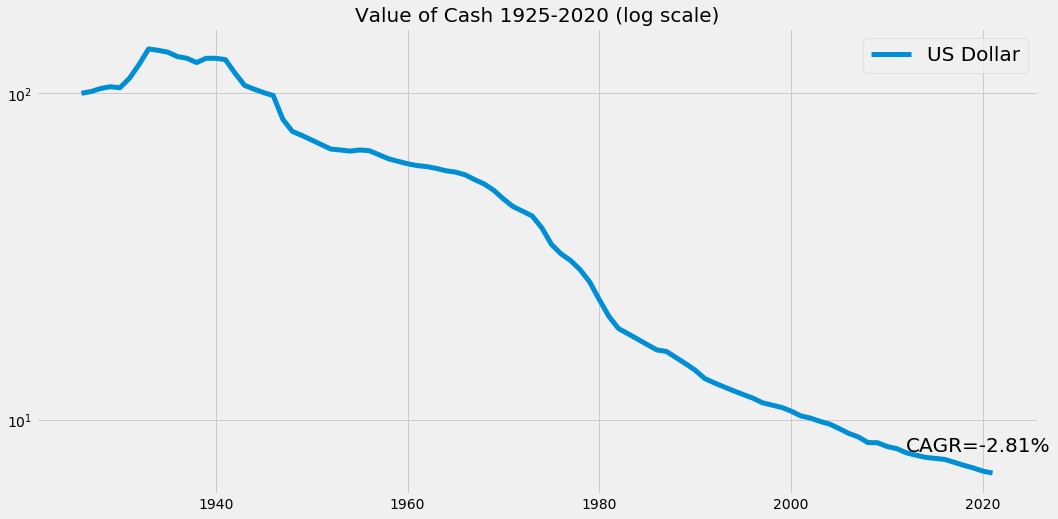

In [6]:
# 현금 실질수익률 그래프

fig = plt.figure(figsize=(16,8))
plt.plot(cpi['cpiret'], linewidth=5, label='US Dollar')
plt.text(cpi.index[-10],8,'CAGR={}%'.format(cagr_cpi),
        color='black',
        fontsize=20)
plt.yscale('log')
plt.title('Value of Cash 1925-2020 (log scale)', fontsize=20)
plt.legend(fontsize=20)

plt.savefig('cash-plot.png')
plt.show()

In [7]:
log_t90_cumsum = np.cumsum(df1['t90ret'] - df1['cpiret'])
t90 = pd.DataFrame(np.exp(log_t90_cumsum)*100, columns=['t90ret'])
cagr_t90 = (t90['t90ret'][-1] / t90['t90ret'][0]) ** (1/len(t90)) - 1
cagr_t90 = (cagr_t90*100).round(2)

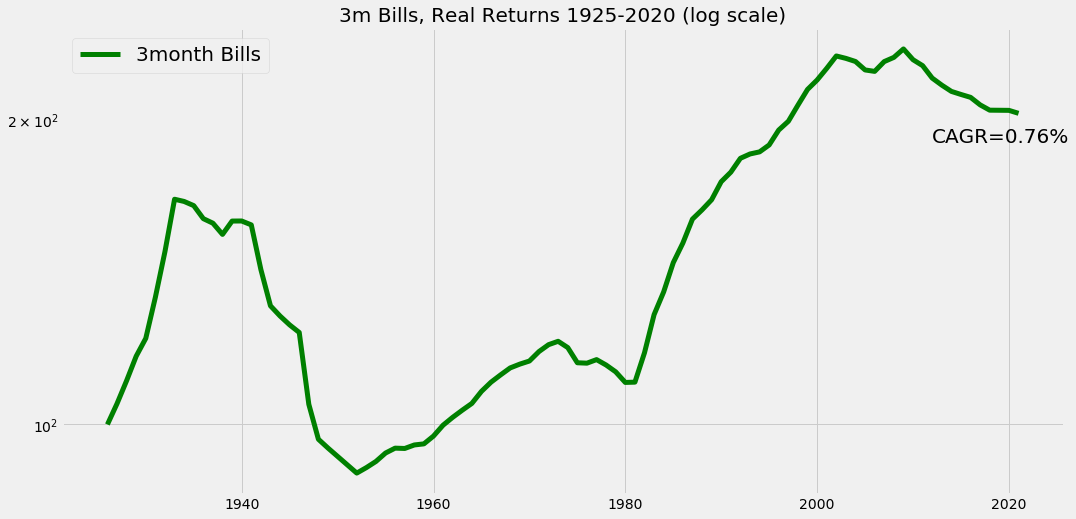

In [8]:
# 3개월 미국채 실질수익률

plt.figure(figsize=(16,8))
plt.plot(t90['t90ret'], linewidth=5, label='3month Bills', color='g')
plt.text(t90.index[-10],190,'CAGR={}%'.format(cagr_t90),
        color='black',
        fontsize=20)
plt.yscale('log')
plt.title('3m Bills, Real Returns 1925-2020 (log scale)', fontsize=20)
plt.legend(fontsize=20)

plt.savefig('t90-plot.png')
plt.show()

In [9]:
log_b10_cumsum = np.cumsum(df1['b10ret'] - df1['cpiret'])
b10 = pd.DataFrame(np.exp(log_b10_cumsum)*100, columns=['b10ret'])
cagr_b10 = (b10['b10ret'][-1] / b10['b10ret'][0]) ** (1/len(b10)) - 1
cagr_b10 = (cagr_b10*100).round(2)

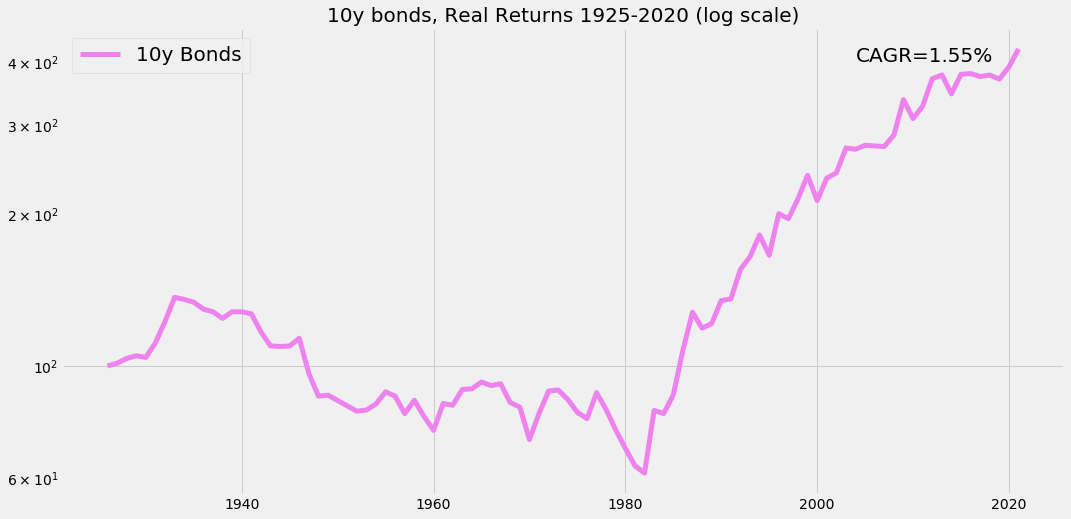

In [10]:
# 10년 미국채 실질수익률

plt.figure(figsize=(16,8))
plt.plot(b10['b10ret'], linewidth=5, label='10y Bonds', color='violet')
plt.text(b10.index[-18],400,'CAGR={}%'.format(cagr_b10),
        color='black',
        fontsize=20)
plt.yscale('log')
plt.title('10y bonds, Real Returns 1925-2020 (log scale)', fontsize=20)
plt.legend(fontsize=20)

plt.savefig('b10-plot.png')
plt.show()

In [11]:
log_sp_cumsum = np.cumsum(df1['sprtrn'] - df1['cpiret'])
sp = pd.DataFrame(np.exp(log_sp_cumsum)*100, columns=['sprtrn'])
cagr_sp = (sp['sprtrn'][-1] / sp['sprtrn'][0]) ** (1/len(sp)) - 1
cagr_sp = (cagr_sp*100).round(2)

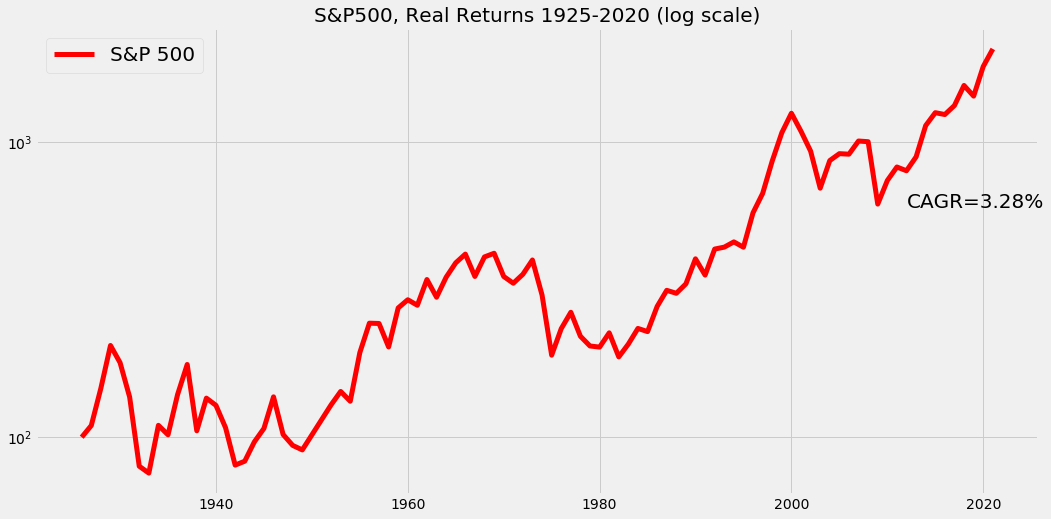

In [12]:
# sp500 실질수익률

plt.figure(figsize=(16,8))
plt.plot(sp['sprtrn'], linewidth=5, label='S&P 500', color='r')
plt.text(sp.index[-10],600,'CAGR={}%'.format(cagr_sp),
        color='black',
        fontsize=20)
plt.yscale('log')
plt.title('S&P500, Real Returns 1925-2020 (log scale)', fontsize=20)
plt.legend(fontsize=20)

plt.savefig('sp500-plot.png')
plt.show()

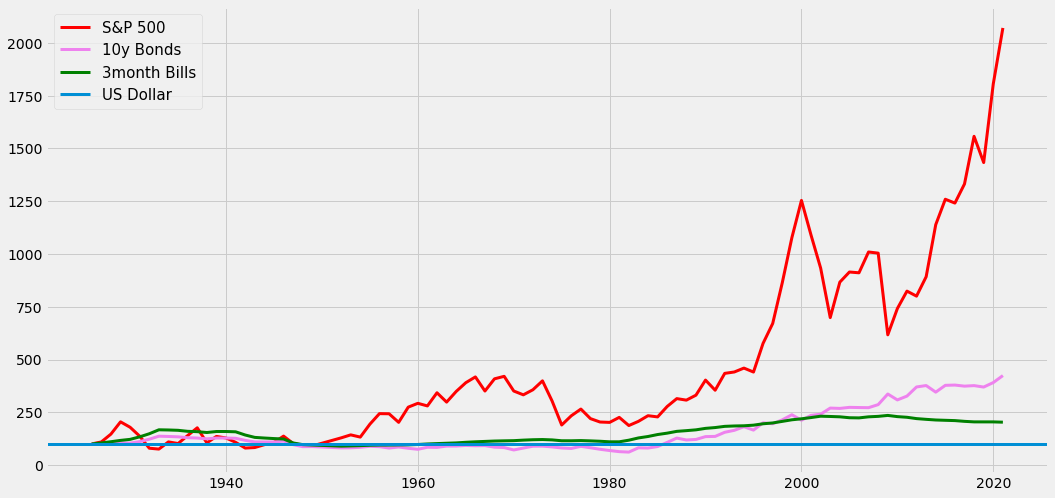

In [13]:
plt.figure(figsize=(16,8))
plt.plot(sp['sprtrn'], linewidth=3, label='S&P 500', color='r')
plt.plot(b10['b10ret'], linewidth=3, label='10y Bonds', color='violet')
plt.plot(t90['t90ret'], linewidth=3, label='3month Bills', color='g')
plt.axhline(100, linewidth=3, label='US Dollar')
# plt.yscale('log')
plt.legend(fontsize=15)

plt.savefig('sum-plot.png')
plt.show()

In [14]:
# yahoo-finance에서 VUSTX fund, S&P500 daily data load
# 미국 장기채 proxy로 VUSTX fund를 사용(평균 17년)

bond = pdr.DataReader(name='VUSTX', data_source='yahoo', start='1925-01-01', end=datetime.datetime.today())
sp500 = pdr.DataReader(name='^GSPC', data_source='yahoo', start='1925-01-01', end=datetime.datetime.today())

# 수정종가를 사용
bond = bond[['Adj Close']]
sp500 = sp500[['Adj Close']]
df2 = pd.merge(sp500, bond, left_index=True, right_index=True)
df2.columns = ['sp500', 'bond']

# 수익률 계산값 추가
df2[['sp500_r', 'bond_r']] = df2.pct_change().fillna(0)
df2

,sp500,bond,sp500_r,bond_r
Date,,,,
1986-05-19,233.199997,0.972669,0.000000,0.000000
1986-05-20,236.110001,0.970724,0.012479,-0.002000
1986-05-21,235.449997,0.980452,-0.002795,0.010021
1986-05-22,240.119995,0.978507,0.019834,-0.001984
1986-05-23,241.350006,0.980452,0.005122,0.001988
...,...,...,...,...
2021-11-16,4700.899902,12.550000,0.003865,-0.001591
2021-11-17,4688.669922,12.630000,-0.002602,0.006374
2021-11-18,4704.540039,12.670000,0.003385,0.003167


In [15]:
df2.describe()

,sp500,bond,sp500_r,bond_r
count,8953.000000,8953.000000,8953.000000,8953.000000
mean,1295.655969,5.171387,0.000403,0.000310
std,901.249073,3.521572,0.011610,0.006828
min,223.919998,0.907617,-0.204669,-0.058748
25%,500.709991,2.078647,-0.004295,-0.003378
50%,1162.829956,4.359232,0.000643,0.000000
75%,1527.349976,8.166805,0.005687,0.004141
max,4704.540039,14.476423,0.115800,0.077566


Skewness: -0.8145


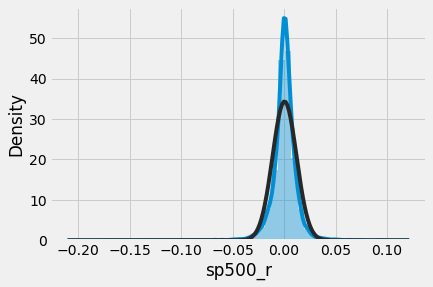

In [16]:
# 수익률 분포와 정규분포 차이, 왜도 확인
fig = plt.figure()
sns.distplot(df2['sp500_r'], fit=norm)
print('Skewness: {:.4f}'.format(skew(df2['sp500_r'])))

Skewness: 0.2247


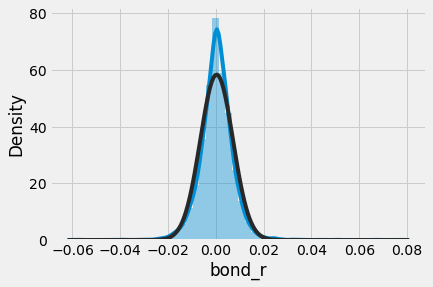

In [17]:
fig = plt.figure()
sns.distplot(df2['bond_r'], fit=norm)
print('Skewness: {:.4f}'.format(skew(df2['bond_r'])))
# 정규분포에서 크게 벗어나지 않으므로 그대로 사용

In [18]:
# S&P500 수익률과 채권 수익률 상관관계

df2[['sp500_r', 'bond_r']].corr()

,sp500_r,bond_r
sp500_r,1.000000,-0.193689
bond_r,-0.193689,1.000000


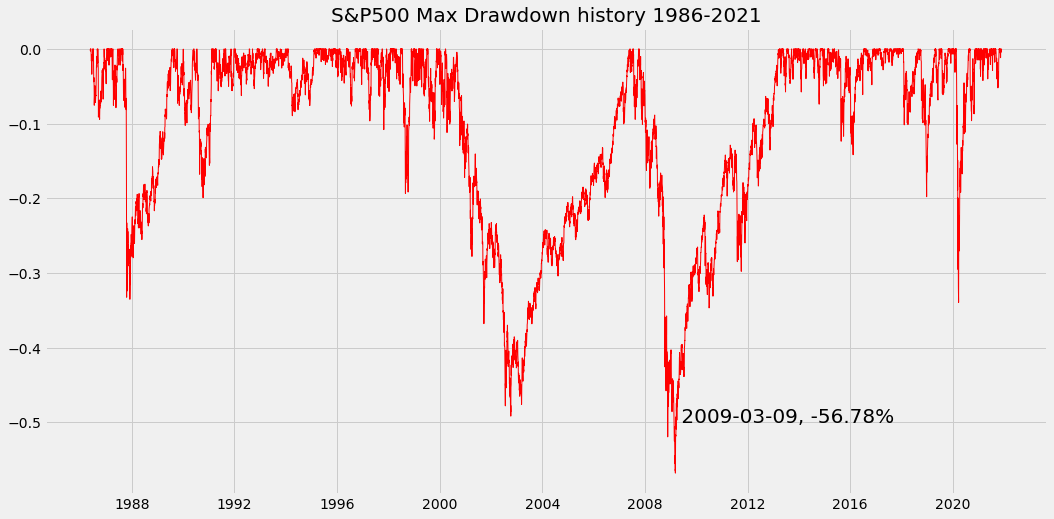

In [19]:
# MDD 그래프 그리기

wealth = (1+df2['sp500_r']).cumprod()
previous_peak = wealth.cummax()
drawdown = (wealth - previous_peak) / previous_peak
min_day = drawdown[drawdown == drawdown.min()]
min_str = str(min_day.index[0]).split(' ')[0]
mdd_sp = drawdown.min()

fig = plt.figure(figsize=(16,8))
plt.title('S&P500 Max Drawdown history 1986-2021', fontsize=20)
plt.text(min_day.index, -0.5, ' {}, {:.2f}%'.format(min_str, drawdown.min()*100), fontsize=20)
plt.plot(drawdown, c='r', linewidth=1)
plt.savefig('sp500-mdd.png')
plt.show()

In [20]:
# cagr 계산

cagr_sp = (1+df2['sp500_r']).prod() ** (252/len(df2)) - 1
cagr_bond = (1+df2['bond_r']).prod() ** (252/len(df2)) - 1

In [21]:
# Volatiliy 계산

vol_sp = (np.std(df2[['sp500_r', 'bond_r']]) * np.sqrt(252))[0]
vol_bond = (np.std(df2[['sp500_r', 'bond_r']]) * np.sqrt(252))[1]

# Sharpe ratio

sharpe_sp = cagr_sp / vol_sp
sharpe_bond = cagr_bond / vol_bond

In [22]:
# 채권 MDD

wealth_bond = (1+df2['bond_r']).cumprod()
previous_peak_bond = wealth_bond.cummax()
drawdown_bond = (wealth_bond - previous_peak_bond) / previous_peak_bond
mdd_bond = drawdown_bond.min()

In [23]:
tr_sp = (1+df2['sp500_r']).prod()
tr_bond = (1+df2['bond_r']).prod()

In [24]:
# Summary DataFrame

summary_df = pd.DataFrame({
                            'Total Return': [tr_sp, tr_bond],
                            'Annual Vol': [vol_sp, vol_bond],
                            'Annual Return': [cagr_sp, cagr_bond],
                            'Sharpe Ratio': [sharpe_sp, sharpe_bond],
                            'MDD': [mdd_sp, mdd_bond]
                        }).round(3).T
summary_df.columns = ['S&P500', 'Bonds']
summary_df

,S&P500,Bonds
Total Return,20.081,13.005
Annual Vol,0.184,0.108
Annual Return,0.088,0.075
Sharpe Ratio,0.478,0.691
MDD,-0.568,-0.202


In [25]:
# S&P500 200일 이평선

df2_ma = df2
df2_ma['sp500_ma'] = talib.MA(sp500['Adj Close'], timeperiod=200).shift(1)
# 오늘 종가로 계산된 MA를 내일 활용하기 때문에 1칸 shift
df2_ma

,sp500,bond,sp500_r,bond_r,sp500_ma
Date,,,,,
1986-05-19,233.199997,0.972669,0.000000,0.000000,208.454300
1986-05-20,236.110001,0.970724,0.012479,-0.002000,208.659750
1986-05-21,235.449997,0.980452,-0.002795,0.010021,208.882900
1986-05-22,240.119995,0.978507,0.019834,-0.001984,209.107050
1986-05-23,241.350006,0.980452,0.005122,0.001988,209.368000
...,...,...,...,...,...
2021-11-16,4700.899902,12.550000,0.003865,-0.001591,4257.545193
2021-11-17,4688.669922,12.630000,-0.002602,0.006374,4261.918142
2021-11-18,4704.540039,12.670000,0.003385,0.003167,4266.210642


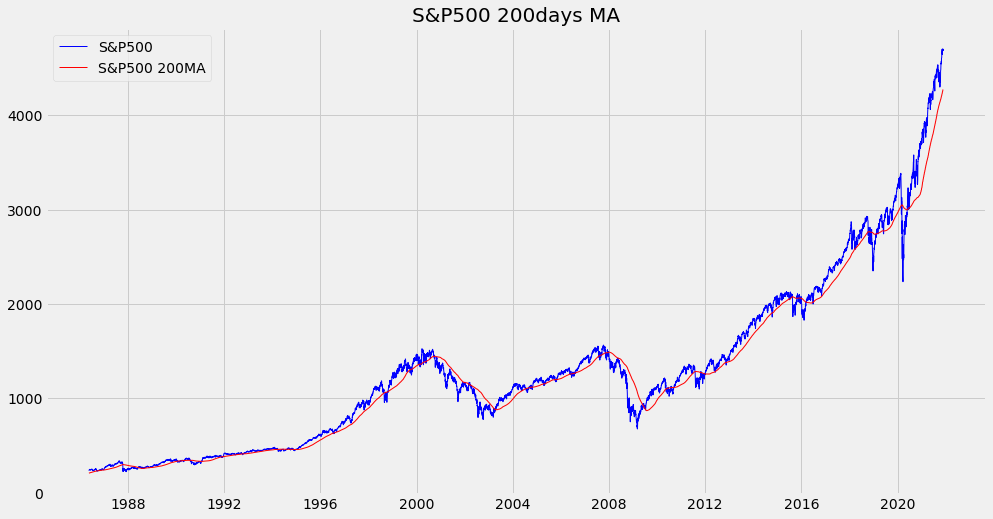

In [26]:
# S&P500과 이평선 그래프

fig = plt.figure(figsize=(15,8))
plt.title('S&P500 200days MA', fontsize=20)
plt.plot(df2_ma['sp500'], c='b', label='S&P500', linewidth=1)
plt.plot(df2_ma['sp500_ma'], c='r', label='S&P500 200MA', linewidth=1)
plt.legend()
plt.savefig('sp_ma200')
plt.show()

In [27]:
# 200일 이평선으로 거래하는 데이터프레임
timing = df2_ma[['sp500', 'sp500_r', 'sp500_ma']]
timing['sp500_r'] = 0
timing['signal'] = np.where(timing['sp500'] > timing['sp500_ma'], 1, 0)

# S&P500이 이평선보다 높아질때 매수
timing['buy'] = (timing['signal'] == 1) & (timing['signal'].shift(1) != 1)
# 낮아질때 매도
timing['sell'] = (timing['signal'] == 0) & (timing['signal'].shift(1) == 1)
# 마지막날 매도하는 것으로 처리해서 수익률 계산
timing.sell[-1] = True

In [28]:
# 거래일 정보 저장

buy_date = timing[timing.buy == True].index
sell_date = timing[timing.sell == True].index

In [29]:
# 거래일에만 수익률을 가져옴

for i in range(len(buy_date)):
    timing.loc[buy_date[i]+datetime.timedelta(days=1):sell_date[i], 'sp500_r'] = df2_ma.loc[buy_date[i]+datetime.timedelta(days=1):sell_date[i], 'sp500_r'] 

In [30]:
(1+timing['sp500_r']).cumprod()

Date
1986-05-19     1.000000
1986-05-20     1.012479
1986-05-21     1.009648
1986-05-22     1.029674
1986-05-23     1.034949
                ...    
2021-11-16    11.610226
2021-11-17    11.580020
2021-11-18    11.619216
2021-11-19    11.602965
2021-11-22    11.565869
Name: sp500_r, Length: 8953, dtype: float64

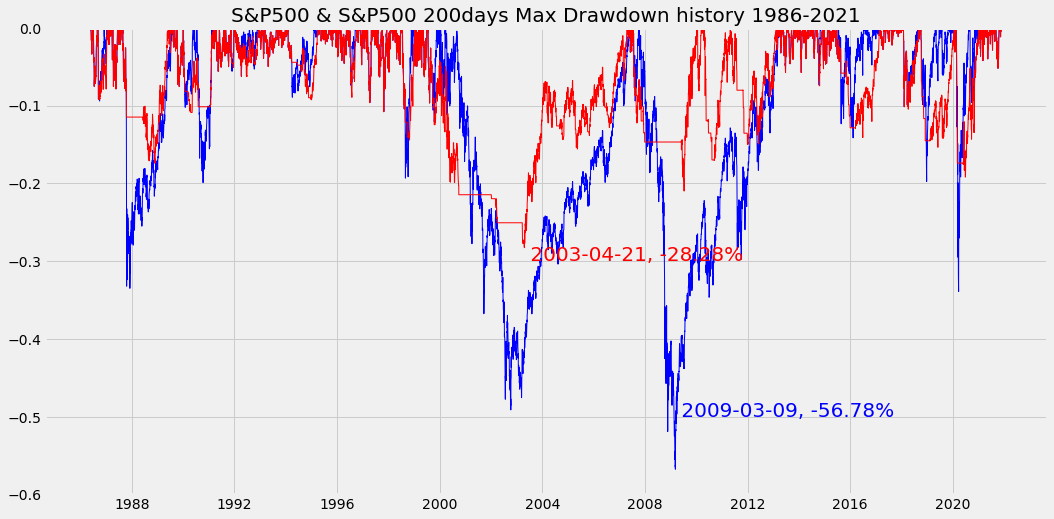

In [31]:
# MDD 그래프 그리기

#수익
wealth = (1+df2['sp500_r']).cumprod()
#전고점
previous_peak = wealth.cummax()
#MDD
drawdown = (wealth - previous_peak) / previous_peak
min_day = drawdown[drawdown == drawdown.min()]
min_str = str(min_day.index[0]).split(' ')[0]
mdd_sp = drawdown.min()

wealth_ma = (1+timing['sp500_r']).cumprod()
previous_peak_ma = wealth_ma.cummax()
drawdown_ma = (wealth_ma - previous_peak_ma) / previous_peak_ma
min_day_ma = drawdown_ma[drawdown_ma == drawdown_ma.min()]
min_str_ma = str(min_day_ma.index[0]).split(' ')[0]
mdd_sp_ma = drawdown_ma.min()

fig = plt.figure(figsize=(16,8))
plt.title('S&P500 & S&P500 200days Max Drawdown history 1986-2021', fontsize=20)
plt.text(min_day.index, -0.5, ' {}, {:.2f}%'.format(min_str, drawdown.min()*100), fontsize=20, c='b')
plt.text(min_day_ma.index, -0.3, ' {}, {:.2f}%'.format(min_str_ma, drawdown_ma.min()*100), fontsize=20, c='r')
plt.plot(drawdown, c='b', linewidth=1)
plt.plot(drawdown_ma, c='r', linewidth=1)
plt.ylim(-0.6, 0)
plt.savefig('sp500+ma_mdd.png')
plt.show()

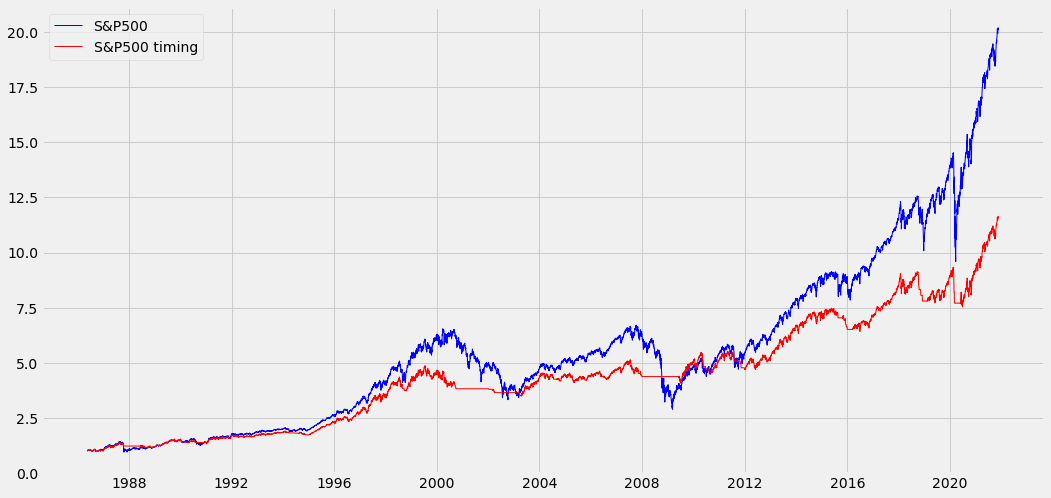

In [32]:
fig = plt.figure(figsize=(16,8))
plt.plot((1+df2_ma['sp500_r']).cumprod(), c='b', label='S&P500', linewidth=1)
plt.plot((1+timing['sp500_r']).cumprod(), c='r', label='S&P500 timing', linewidth=1)
plt.legend()
plt.savefig('sp500time-plot.png')
plt.show()

In [33]:
# cagr 계산
cagr_sp_ma = (1+timing['sp500_r']).prod() ** (252/len(df2)) - 1

# Volatiliy 계산
vol_sp_ma = (np.std(timing['sp500_r']) * np.sqrt(252))

# Sharpe ratio
sharpe_sp_ma = cagr_sp_ma / vol_sp_ma

tr_sp_ma = (1+timing['sp500_r']).prod()

In [34]:
summary_df = pd.DataFrame({
                            'Total Return': [tr_sp, tr_sp_ma],
                            'Annual Vol': [vol_sp, vol_sp_ma],
                            'Annual Return': [cagr_sp, cagr_sp_ma],
                            'Sharpe Ratio': [sharpe_sp, sharpe_sp_ma],
                            'MDD': [mdd_sp, mdd_sp_ma]
                        }).round(3).T
summary_df.columns = ['S&P500', 'S&P500_200MA']
summary_df

,S&P500,S&P500_200MA
Total Return,20.081,11.566
Annual Vol,0.184,0.117
Annual Return,0.088,0.071
Sharpe Ratio,0.478,0.612
MDD,-0.568,-0.283


# Extension 1

In [35]:
## 채권이랑 주식 관계는 어떨까?

In [36]:
ols = sm.OLS(df2['bond_r'], df2['sp500_r'])
result = ols.fit()
para = ols.fit().params
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 bond_r   R-squared (uncentered):                   0.037
Model:                            OLS   Adj. R-squared (uncentered):              0.037
Method:                 Least Squares   F-statistic:                              341.9
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                    6.06e-75
Time:                        16:26:08   Log-Likelihood:                          32101.
No. Observations:                8953   AIC:                                 -6.420e+04
Df Residuals:                    8952   BIC:                                 -6.419e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sp500_r       -0.1129      0.006    -18.490      0.000      -0.125      -0.101
==============================================================================
Omnibus:                     1212.019   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15812.375
Skew:                           0.101   Prob(JB):                         0.00
Kurtosis:                       9.507   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
corr = df2[['sp500_r', 'bond_r']].corr().iloc[0].bond_r

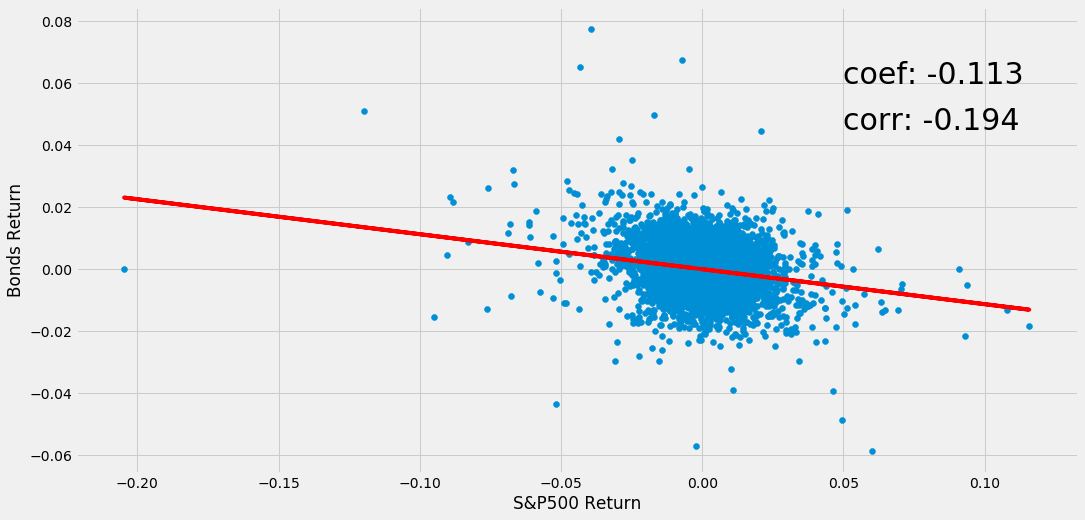

In [38]:
# 선형회귀그래프

fig = plt.figure(figsize=(16,8))
plt.plot(df2['sp500_r'], para.sp500_r*df2['sp500_r'], c='r')
plt.xlabel('S&P500 Return')
plt.ylabel('Bonds Return')
plt.scatter(x=df2['sp500_r'], y=df2['bond_r'])
plt.text(0.05, 0.06, 'coef: {:.3f}'.format(para.sp500_r), fontsize=30)
plt.text(0.05, 0.045, 'corr: {:.3f}'.format(corr), fontsize=30)
plt.savefig('OLS_normal.png')
plt.show()

In [39]:
# 포지션을 가지고 있지 않았을 때(이평선 아래였던 기간)의 채권과 주식 상관관계
timing_ols = timing[timing['sp500_r'] == 0]

timing_ols = timing_ols[['sp500']]
timing_ols = pd.merge(timing_ols, df2[['sp500_r', 'bond', 'bond_r']], left_index=True, right_index=True, how='left')

In [40]:
corr = timing_ols[['sp500_r', 'bond_r']].corr().iloc[0].bond_r

In [41]:
ols = sm.OLS(timing_ols['bond_r'], timing_ols['sp500_r'])
result = ols.fit()
para = ols.fit().params
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 bond_r   R-squared (uncentered):                   0.114
Model:                            OLS   Adj. R-squared (uncentered):              0.113
Method:                 Least Squares   F-statistic:                              276.2
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                    1.90e-58
Time:                        16:26:08   Log-Likelihood:                          7388.8
No. Observations:                2151   AIC:                                 -1.478e+04
Df Residuals:                    2150   BIC:                                 -1.477e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sp500_r       -0.1523      0.009    -16.620      0.000      -0.170      -0.134
==============================================================================
Omnibus:                      408.208   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6784.866
Skew:                           0.399   Prob(JB):                         0.00
Kurtosis:                      11.664   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

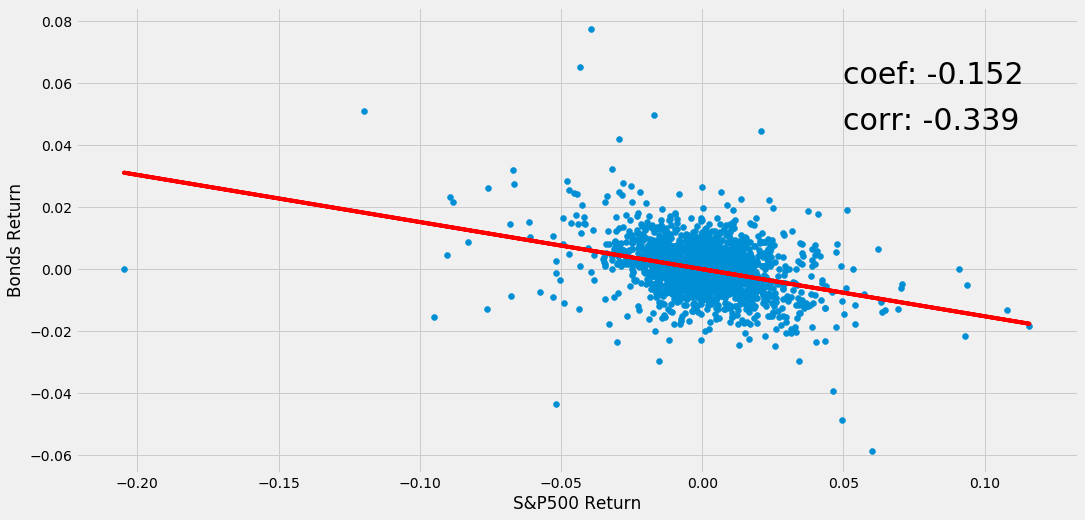

In [42]:
fig = plt.figure(figsize=(16,8))
plt.plot(timing_ols['sp500_r'], para.sp500_r*timing_ols['sp500_r'], c='r')
plt.scatter(x=timing_ols['sp500_r'], y=timing_ols['bond_r'])
plt.xlabel('S&P500 Return')
plt.ylabel('Bonds Return')
plt.text(0.05, 0.06, 'coef: {:.3f}'.format(para.sp500_r), fontsize=30)
plt.text(0.05, 0.045, 'corr: {:.3f}'.format(corr), fontsize=30)
plt.savefig('OLS_timing.png')
plt.show()

In [43]:
# 이평선 아래에 있는 기간동안, 현금 대신 채권을 사면 어떻게 될까?

In [44]:
# 이평선 위에서는 S&P500 수익률을 계산하고 아래에서는 채권 수익률을 계산

timet = pd.concat([timing, df2[['bond_r', 'bond']]], axis=1)
timet['return'] = timet['sp500_r']

timet.loc[timet['sp500_r'] == 0, 'return'] = timet.loc[timet['sp500_r'] == 0, 'bond_r']

In [45]:
(1+timet['return']).cumprod()

Date
1986-05-19     1.000000
1986-05-20     1.012479
1986-05-21     1.009648
1986-05-22     1.029674
1986-05-23     1.034949
                ...    
2021-11-16    26.242225
2021-11-17    26.173953
2021-11-18    26.262546
2021-11-19    26.225814
2021-11-22    26.141966
Name: return, Length: 8953, dtype: float64

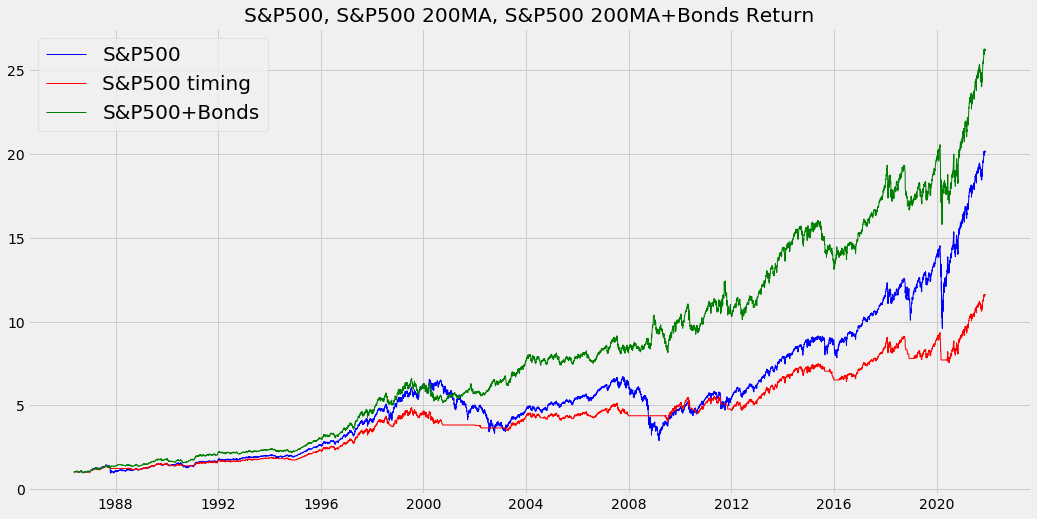

In [46]:
fig = plt.figure(figsize=(16,8))
plt.title('S&P500, S&P500 200MA, S&P500 200MA+Bonds Return')
plt.plot((1+df2_ma['sp500_r']).cumprod(), c='b', label='S&P500', linewidth=1)
plt.plot((1+timing['sp500_r']).cumprod(), c='r', label='S&P500 timing', linewidth=1)
plt.plot((1+timet['return']).cumprod(), c='g', label='S&P500+Bonds', linewidth=1)
plt.legend(prop={'size':20})
plt.savefig('sp500+bondplot.png')
plt.show()

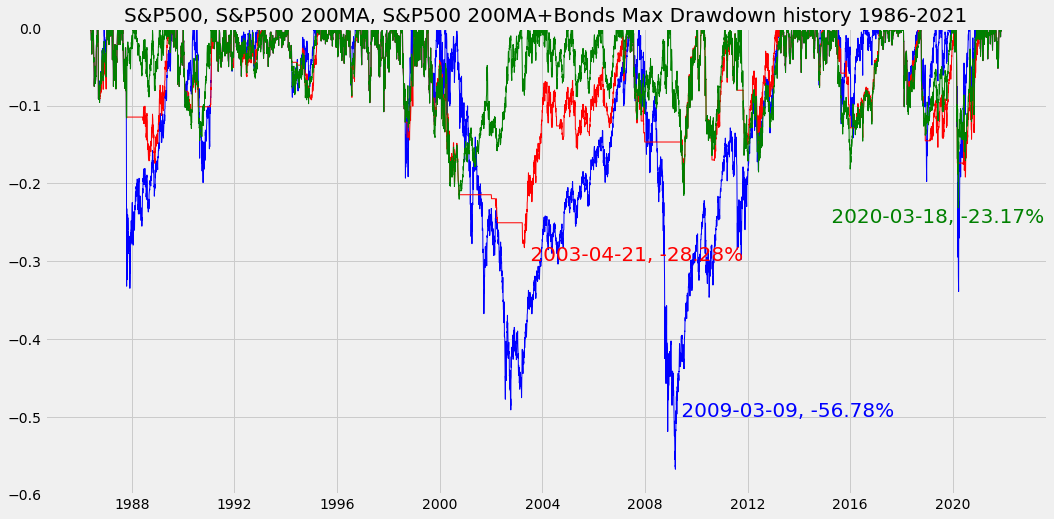

In [47]:
wealth_m = (1+timet['return']).cumprod()
previous_peak_m = wealth_m.cummax()
drawdown_m = (wealth_m - previous_peak_m) / previous_peak_m
min_day_m = drawdown_m[drawdown_m == drawdown_m.min()]
min_str_m = str(min_day_m.index[0]).split(' ')[0]
mdd_sp_bond = drawdown_m.min()

fig = plt.figure(figsize=(16,8))
plt.title('S&P500, S&P500 200MA, S&P500 200MA+Bonds Max Drawdown history 1986-2021', fontsize=20)
plt.plot(drawdown, c='b', linewidth=1)
plt.plot(drawdown_ma, c='r', linewidth=1)
plt.plot(drawdown_m, linewidth=1, c='g')
plt.text((min_day_m.index-datetime.timedelta(days=1900)), -0.25, ' {}, {:.2f}%'.format(min_str_m, drawdown_m.min()*100), fontsize=20, c='g')
plt.text(min_day.index, -0.5, ' {}, {:.2f}%'.format(min_str, drawdown.min()*100), fontsize=20, c='b')
plt.text(min_day_ma.index, -0.3, ' {}, {:.2f}%'.format(min_str_ma, drawdown_ma.min()*100), fontsize=20, c='r')
plt.ylim(-0.6, 0)
plt.savefig('sp500_bonds_mdd.png')
plt.show()

In [48]:
# cagr 계산
cagr_sp_bond = (1+timet['return']).prod() ** (252/len(df2)) - 1

# Volatiliy 계산
vol_sp_bond = (np.std(timet['return']) * np.sqrt(252))

# Sharpe ratio
sharpe_sp_bond = cagr_sp_bond / vol_sp_bond

tr_sp_bond = (1+timet['return']).prod()
summary_df = pd.DataFrame({
                            'Total Return': [tr_sp, tr_sp_ma, tr_sp_bond],
                            'Annual Vol': [vol_sp, vol_sp_ma, vol_sp_bond],
                            'Annual Return': [cagr_sp, cagr_sp_ma, cagr_sp_bond],
                            'Sharpe Ratio': [sharpe_sp, sharpe_sp_ma, sharpe_sp_bond],
                            'MDD': [mdd_sp, mdd_sp_ma, mdd_sp_bond]
                        }).round(3).T
summary_df.columns = ['S&P500', 'S&P500_200MA', 'S&P500+Bonds']
summary_df

,S&P500,S&P500_200MA,S&P500+Bonds
Total Return,20.081,11.566,26.142
Annual Vol,0.184,0.117,0.133
Annual Return,0.088,0.071,0.096
Sharpe Ratio,0.478,0.612,0.723
MDD,-0.568,-0.283,-0.232


# Extension 2

In [49]:
# 평소 주식과 채권은 음의 상관관계를 가지지만, 인플레이션이 높아지는 경우에는 양의 상관관계를 가지게 됨.
# 그러면 인플레이션 증가율 상위 20%에서의 주식과 채권 수익률 관계는?
# 여기서부터는 CRSP 1926 ~ 2020 monthly data

In [50]:
#CRSP 데이터, 위와 동일하게 로그 수익률은 직접 계산함

crsp_sp = pd.read_csv('data/crsp sp500.csv')
crsp_bond = pd.read_csv('data/crsp_montly.csv')

crsp = pd.merge(crsp_sp, crsp_bond, on=['caldt'])

crsp['sprtrn'] = np.log(crsp['spindx']/crsp['spindx'].shift(1))
crsp['b10ret'] = np.log(crsp['b10ind']/crsp['b10ind'].shift(1))
crsp['t90ret'] = np.log(crsp['t90ind']/crsp['t90ind'].shift(1))
crsp['cpiret'] = np.log(crsp['cpiind']/crsp['cpiind'].shift(1))
crsp = crsp.fillna(0)
crsp['caldt'] = pd.to_datetime(crsp['caldt'])
crsp.index = crsp['caldt']
crsp.index.name = 'date'
crsp = crsp[['spindx', 'sprtrn', 'b10ret', 'b10ind', 't90ret', 't90ind', 'cpiret', 'cpiind']]
crsp

,spindx,sprtrn,b10ret,b10ind,t90ret,t90ind,cpiret,cpiind
date,,,,,,,,
1925-12-31,12.46,0.000000,0.000000,46.97544,0.000000,34.83693,0.000000,42.1
1926-01-30,12.74,0.022223,0.000000,46.97544,0.004034,34.97774,0.000000,42.1
1926-02-27,12.18,-0.044951,0.000000,46.97544,0.003232,35.09096,0.000000,42.1
1926-03-31,11.46,-0.060933,0.000000,46.97544,0.002774,35.18843,-0.004762,41.9
1926-04-30,11.72,0.022434,0.000000,46.97544,0.003067,35.29653,0.004762,42.1
...,...,...,...,...,...,...,...,...
2020-08-31,3500.31,0.067719,-0.014818,2944.91700,0.000069,1029.47700,0.003275,611.6
2020-09-30,3363.00,-0.040018,0.002557,2952.45600,0.000099,1029.57900,0.001307,612.4
2020-10-30,3269.96,-0.028056,-0.017463,2901.34600,0.000067,1029.64800,0.000490,612.7


In [51]:
# CRSP 데이터에서 채권 주식 상관관계는 0.05 정도
crsp[['sprtrn', 'b10ret']].corr()

,sprtrn,b10ret
sprtrn,1.00000,0.04954
b10ret,0.04954,1.00000


In [71]:
# 특정일 이후부터 주식과 채권 수익률 상관관계
# 2000년 이후로 음의 상관관계를 갖다가 코로나 이후로 양의 상관관계를 가짐

period = '2020-4'

crsp_period = crsp[period:]
crsp_period[['sprtrn', 'b10ret']].corr()

,sprtrn,b10ret
sprtrn,1.000000,0.346936
b10ret,0.346936,1.000000


In [53]:
# CPI return을 기준으로 내림차순 정렬
sort_crsp = crsp.sort_values(by=['cpiret'], ascending=False)

# 20%에 해당하는 값
q = int(np.ceil(len(sort_crsp)*0.2))

corr_list = []

# 각 분위마다 S&P500 수익률과 Bonds 수익률의 Correlation 계산
for i in range(5):
    corr_list.append(sort_crsp[['sprtrn', 'b10ret']][q*i:q*(i+1)].corr().sprtrn[1])

In [54]:
# 20%에 속하는 데이터 갯수
q

226

In [55]:
# 각 구간에서의 상관계수
corr_list

[0.1680969759274826,
 0.10114451677106066,
 0.07378062484334082,
 -0.02289968048049385,
 -0.04870676574972664]

In [56]:
# 상위 20%
q1 = sort_crsp[['sprtrn', 'b10ret']][0:q]

In [57]:
ols = sm.OLS(q1.b10ret, q1.sprtrn)
result = ols.fit()
para = ols.fit().params
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 b10ret   R-squared (uncentered):                   0.029
Model:                            OLS   Adj. R-squared (uncentered):              0.025
Method:                 Least Squares   F-statistic:                              6.823
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                     0.00960
Time:                        16:26:10   Log-Likelihood:                          585.55
No. Observations:                 226   AIC:                                     -1169.
Df Residuals:                     225   BIC:                                     -1166.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sprtrn         0.0628      0.024      2.612      0.010       0.015       0.110
==============================================================================
Omnibus:                       22.387   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               75.433
Skew:                           0.270   Prob(JB):                     4.17e-17
Kurtosis:                       5.778   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
result.rsquared

0.029433346499214585

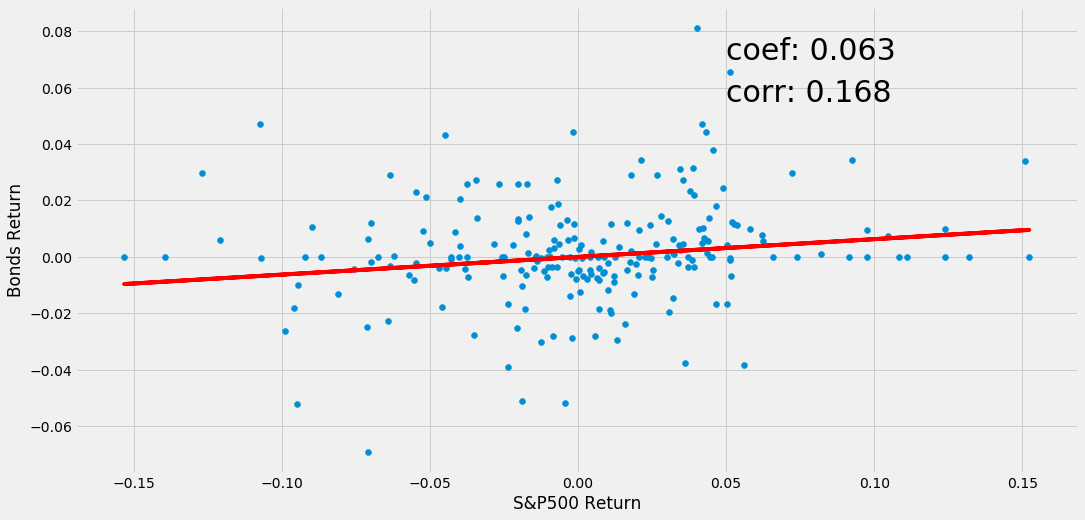

In [59]:
fig = plt.figure(figsize=(16,8))
plt.plot(q1['sprtrn'], para.sprtrn*q1['sprtrn'], c='r')
plt.scatter(x=q1['sprtrn'], y=q1['b10ret'])
plt.xlabel('S&P500 Return')
plt.ylabel('Bonds Return')
plt.text(0.05, 0.07, 'coef: {:.3f}'.format(para.sprtrn), fontsize=30)
plt.text(0.05, 0.055, 'corr: {:.3f}'.format(corr_list[0]), fontsize=30)
plt.savefig('OLS_q1.png')
plt.show()

In [60]:
# CPI Return 하위 20%의 경우

q5 = sort_crsp[['sprtrn', 'b10ret']][-q:]
ols = sm.OLS(q5.b10ret, q5.sprtrn)
result = ols.fit()
para = ols.fit().params
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 b10ret   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.003
Method:                 Least Squares   F-statistic:                             0.3303
Date:                Tue, 23 Nov 2021   Prob (F-statistic):                       0.566
Time:                        16:26:10   Log-Likelihood:                          611.17
No. Observations:                 226   AIC:                                     -1220.
Df Residuals:                     225   BIC:                                     -1217.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sprtrn        -0.0094      0.016     -0.575      0.566      -0.041       0.023
==============================================================================
Omnibus:                       52.705   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.954
Skew:                           0.813   Prob(JB):                     1.06e-53
Kurtosis:                       7.823   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

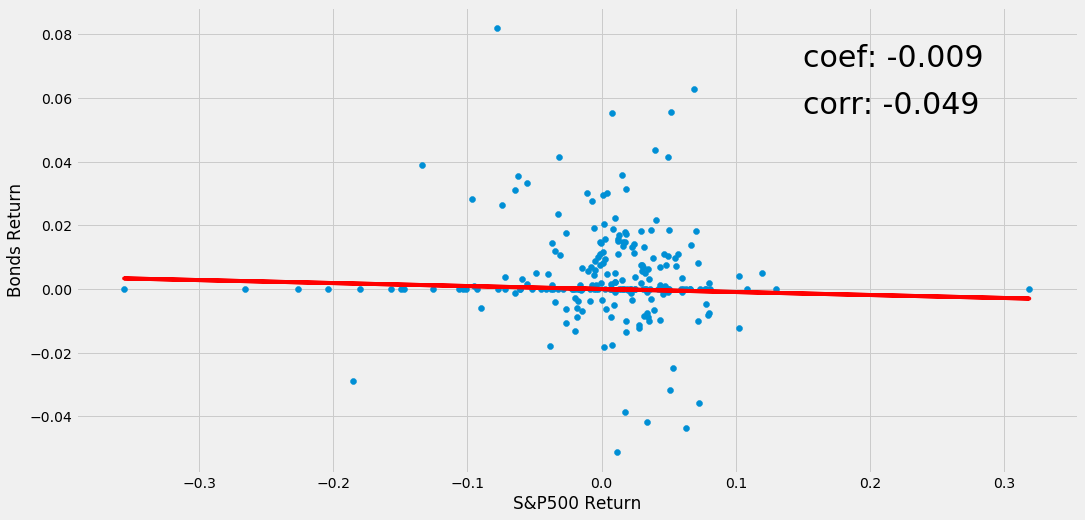

In [61]:
fig = plt.figure(figsize=(16,8))
plt.plot(q5['sprtrn'], para.sprtrn*q5['sprtrn'], c='r')
plt.scatter(x=q5['sprtrn'], y=q5['b10ret'])
plt.xlabel('S&P500 Return')
plt.ylabel('Bonds Return')
plt.text(0.15, 0.07, 'coef: {:.3f}'.format(para.sprtrn), fontsize=30)
plt.text(0.15, 0.055, 'corr: {:.3f}'.format(corr_list[-1]), fontsize=30)
plt.savefig('OLS_q5.png')
plt.show()

In [62]:
## 결론
## 무지성으로 주식 대신 채권을 사면 안된다.
## 인플레이션에 따라 상관관계가 달라지니까 고려해야 함.
## 화이팅!